In [3]:
from src.tools_dev import Mapdisplay, random_point_in_shp
import ee
import tensorflow as tf
import geopandas as gpd
from shapely.geometry import Point, Polygon
from folium.plugins import MarkerCluster
import numpy as np
from src.tools_dev import get_bound_points, generate_box_buffer, \
                            generate_ee_points, get_landsat_data
import geopy.distance
import rasterio
import matplotlib.pyplot as plt
import pandas as pd

import folium
print('Folium version: ' + folium.__version__)

# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'
ee.Initialize()
%load_ext autoreload
%autoreload 2
%matplotlib inline

Folium version: 0.11.0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
def normalize(img):
    return (img-np.nanmin(img))/(np.nanmax(img)-(np.nanmin(img)))

def clipper(img):
    return img.clip(fc)
  
def addTime(image): 
    constant = 1000 * 60 * 60 * 24 * 365
    return image.addBands(image.metadata('system:time_start').divide(constant))

def fill(image):
    filled1a = image.focal_mean(2, 'square', 'pixels', 1).blend(image)
    return filled1a.set('system:time_start',image.get('system:time_start'))

def l8remap(image):
    return image.rename(\
                        ['B0','B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11'])

def addNDVI(image): 
    ndvi = image.normalizedDifference(['B4', 'B3']).rename('NDVI')
    return image.addBands(ndvi)

def addEVI(image):
    evi = image.expression('2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',\
                           {'NIR': image.select('B4'),\
                            'RED': image.select('B3'),
                            'BLUE': image.select('B1')}).rename('EVI')
    return image.addBands(evi)

def landsat_collection_generator(bounds, cloud_thr={'l5':20,'l7':20,'l8':10}):
    L5coll = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR')\
        .filter(ee.Filter.lt('CLOUD_COVER',cloud_thr['l5']))\
        .filterBounds(bounds)

    L7coll = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR')\
        .filter(ee.Filter.lt('CLOUD_COVER',cloud_thr['l7']))\
        .filterBounds(bounds)\
        .map(fill)\
        .filter(ee.Filter.calendarRange(2012,2013,'year'))
    # add filter to only use 1 year of L7

    L8coll = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')\
        .filter(ee.Filter.lt('CLOUD_COVER',cloud_thr['l8']))\
        .filterBounds(bounds)\
        .map(l8remap)

    #Build landsat collection
    landsat = ee.ImageCollection(L5coll.merge(L7coll.merge(L8coll)))\
        .map(addNDVI)\
        .map(addEVI)
        
    return landsat
 
def image_collection_export(ic, outbands, BUCKET, PREFIX, DESC, REGION):
    task = ee.batch.Export.image.toCloudStorage(\
                                         image = ic,\
                                         description = DESC,\
                                         bucket = BUCKET,\
                                         fileNamePrefix = PREFIX,\
                                         scale = 30,\
                                         region = REGION)
    task.start()    
    return 

def landsat_aggregate(landsat_ic, outbands, years, month_range):
    landsat_images = []
    for year in years:
        renamed = [f'{b}_{year}' for b in outbands]
        landsat_annual = landsat_ic.filter(ee.Filter.calendarRange(int(year),int(year),'year'))\
            .filter(ee.Filter.calendarRange(int(month_range[0]),int(month_range[1]),'month'))\
            .select(outbands)\
            .median()\
            .rename(renamed)
        landsat_images.append(landsat_annual)

    out = ee.Image.cat(landsat_images)    
    return out
    

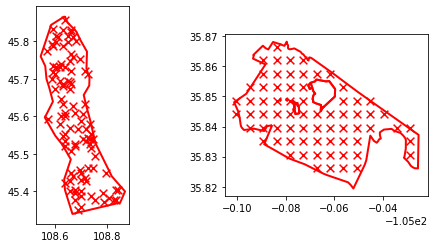

In [10]:
####quick sanity check#######
BUCKET = 'rio-mora'
BUCKETS = ['ikh-nart','rio-mora']
fig, ax = plt.subplots(1,2,figsize=(8,4))
for i,BUCKET in enumerate(BUCKETS):
    if BUCKET == 'rio-mora':
        shp = './data/shp/RioMoraNWRBndry_2019/RioMoraNWRBndry_2019.shp'
        pointsfile = f'/datadrive/{BUCKET}/wdpa-555609346_points_v1.csv'
        
    if BUCKET == 'ikh-nart':
        shp = './data/shp/IN_boundary/IN_boundary.shp'
        pointsfile = f'/datadrive/{BUCKET}/wdpa-99848_points_v1.csv'
    df = gpd.read_file(shp).to_crs("EPSG:4326")
    pnts = pd.read_csv(pointsfile)
    pnts = gpd.GeoDataFrame(pnts, geometry=gpd.points_from_xy(pnts.Longitude,pnts.Latitude))
        
    pnts.plot(ax=ax[i], marker='x', color='red', markersize=60)
    df.plot(ax=ax[i], facecolor='none', edgecolor='red', lw=2)

In [19]:
#BUCKET = 'ikh-nart'
BUCKET = 'rio-mora'
BUCKETS = ['ikh-nart','rio-mora']

for BUCKET in BUCKETS:
    if BUCKET == 'rio-mora':
        shp = './data/shp/RioMoraNWRBndry_2019/RioMoraNWRBndry_2019.shp'
        #shp = './data/shp/MRW/Mora River Watershed July2011.shp'
    elif BUCKET == 'ikh-nart':
        shp = './data/shp/IN_boundary/IN_boundary.shp'
        target_months = (6,10) 

    #need an automated way of determining growing season....
    df = gpd.read_file(shp).to_crs("EPSG:4326")
    df = df[df.area==np.max(df.area)].reset_index()
    xmin, ymin, xmax, ymax = df.bounds.values[0]

    x,y = df.geometry[0].exterior.coords.xy
    cords = np.dstack((x,y)).tolist()
    g = ee.Geometry.Polygon(cords)
    feature = ee.Feature(g)
    fc = ee.FeatureCollection([feature])
    REGION = g.getInfo()['coordinates']


    years = np.arange(1986,2021) 
    # Define a FeatureCollection fc above
    #Build landsat collection
    cloud_thr = {'l5':25,'l7':20,'l8':10}
    landsat = landsat_collection_generator(bounds=fc,cloud_thr=cloud_thr)
    landsat = landsat.map(clipper)
  
    '''
    ######## ALL BANDS #############
    DESC = f'{BUCKET}_growingseason'
    PREFIX = 'processed/allbands'
    landsat_images = []
    outbands = ['B5', 'B4', 'B3', 'B2', 'B1','NDVI','EVI']
    if BUCKET == 'rio-mora':
        target_months = (4,10) 
    elif BUCKET == 'ikh-nart':
        target_months = (6,10)
    out = landsat_aggregate(landsat, outbands, years, target_months)
    #export these to bucket
    image_collection_export(out, outbands, BUCKET, PREFIX, DESC, REGION)
    del out
   
    ######## NDVI BAND #############
    DESC = f'{BUCKET}_growingseason_ndvi'
    PREFIX = 'processed/ndvi'
    landsat_images = []
    outbands = ['NDVI']
    if BUCKET == 'rio-mora':
        target_months = (4,10) 
    elif BUCKET == 'ikh-nart':
        target_months = (6,10) 
    out = landsat_aggregate(landsat, outbands, years, target_months)
    #export these to bucket
    image_collection_export(out, outbands, BUCKET, PREFIX, DESC, REGION)
    del out
  
    ######## PEAK BAND #############
    DESC = f'{BUCKET}_growingseason_color'
    PREFIX = 'processed/peakcolor'
    landsat_images = []
    outbands = ['B3','B2','B1']
    if BUCKET == 'rio-mora':
        target_months = (6,8) 
    elif BUCKET == 'ikh-nart':
        target_months = (6,9) 
    out = landsat_aggregate(landsat, outbands, years, target_months).float() 
    #export these to bucket
    image_collection_export(out, outbands, BUCKET, PREFIX, DESC, REGION)
    del out
    ''' 
    ######## EVI BAND #############
    DESC = f'{BUCKET}_growingseason_evi'
    PREFIX = 'processed/evi'
    landsat_images = []
    outbands = ['EVI']
    if BUCKET == 'rio-mora':
        target_months = (4,10) 
    elif BUCKET == 'ikh-nart':
        target_months = (6,10) 
    out = landsat_aggregate(landsat, outbands, years, target_months)
    #export these to bucket
    image_collection_export(out, outbands, BUCKET, PREFIX, DESC, REGION)
    del out


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  from ipykernel import kernelapp as app
